In [50]:
import numpy as np
import pandas as pd
import yaml
import torch
from copy import deepcopy
from tqdm import tqdm
import matplotlib.pyplot as plt
from celldreamer.eval.eval_utils import normalize_and_compute_metrics
from celldreamer.eval.evaluate import compute_prdc
import scipy.sparse as sp

from torch import nn
import scanpy as sc    

from celldreamer.data.scrnaseq_loader import RNAseqLoader
from celldreamer.models.featurizers.category_featurizer import CategoricalFeaturizer
from celldreamer.models.fm.denoising_model import SimpleMLPTimeStep
from celldreamer.models.fm.fm import FM
from celldreamer.eval.optimal_transport import wasserstein
import random
from celldreamer.models.base.encoder_model import EncoderModel
from celldreamer.models.base.utils import unsqueeze_right

device  = "cuda" if torch.cuda.is_available() else "cpu"

**Util function**

In [51]:
def init_feature_embeddings(dataset, dataset_config, device):
    feature_embeddings = {}  
    num_classes = {}
            
    for cov, cov_names in dataset.id2cov.items():
        feature_embeddings[cov] = CategoricalFeaturizer(len(cov_names), 
                                                                  dataset_config["one_hot_encode_features"], 
                                                                  device, 
                                                                  embedding_dimensions=dataset_config["cov_embedding_dimensions"])
        if dataset_config["one_hot_encode_features"]:
            num_classes[cov] = len(cov_names)
        else:
            num_classes[cov] = dataset_config["cov_embedding_dimensions"]
    return feature_embeddings

## Step 1: Initialize data

In [52]:
dataset_config = {'dataset_path': '../../datasets/processed/neurips.h5ad',
                    'layer_key': 'X_counts',
                    'covariate_keys': ['cell_type'],
                    'conditioning_covariate': 'cell_type',
                    'subsample_frac': 1,
                    'encoder_type': 'learnt_autoencoder',
                    'target_max': 1,
                    'target_min': -1,
                    'one_hot_encode_features': False,
                    'split_rates': [0.90, 0.05, 0.05],
                    'cov_embedding_dimensions': 256}

data_path = dataset_config["dataset_path"]

dataset = RNAseqLoader(data_path=data_path,
                                layer_key=dataset_config["layer_key"],
                                covariate_keys=dataset_config["covariate_keys"],
                                subsample_frac=dataset_config["subsample_frac"], 
                                encoder_type=dataset_config["encoder_type"],
                                target_max=dataset_config["target_max"], 
                                target_min=dataset_config["target_min"])

dataloader = torch.utils.data.DataLoader(dataset,
                                            batch_size=256,
                                            shuffle=True,
                                            num_workers=4, 
                                            drop_last=True)

in_dim = dataset.X.shape[1]
size_factor_statistics = {"mean": dataset.log_size_factor_mu, 
                                  "sd": dataset.log_size_factor_sd}
scaler = dataset.get_scaler()
n_cat = len(dataset.id2cov["cell_type"])

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


learnt_autoencoder


## Step 2: Initialize encoder

In [53]:
encoder_config = {
    "x0_from_x_kwargs": {
        "dims": [512, 256, 50],
        # "dims": [500, 300, 200],
        "batch_norm": True,
        "dropout": False,
        "dropout_p": 0.0
    },
    "learning_rate": 0.001,
    "weight_decay": 0.00001,
    "covariate_specific_theta": False
}

# state_dict_path = "/home/icb/alessandro.palma/environment/celldreamer/project_folder/experiments/train_autoencoder_neurips_200/c83bcc09-d9f3-4e22-b6b4-ae4f4fa9d917/checkpoints/epoch_199.ckpt"
state_dict_path = "/home/icb/alessandro.palma/environment/celldreamer/project_folder/experiments/train_autoencoder_neurips/e175592b-46a0-4674-baba-db77dd8a079a/checkpoints/last.ckpt"

In [54]:
encoder_model = EncoderModel(in_dim=in_dim,
                              scaler=scaler, 
                              n_cat=n_cat,
                              conditioning_covariate=dataset_config["conditioning_covariate"], 
                              encoder_type=dataset_config["encoder_type"],
                              **encoder_config)

encoder_model.load_state_dict(torch.load(state_dict_path)["state_dict"])

encoder_model.eval()

EncoderModel(
  (x0_from_x): MLP(
    (net): Sequential(
      (0): Sequential(
        (0): Linear(in_features=2002, out_features=512, bias=True)
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ELU(alpha=1.0)
      )
      (1): Sequential(
        (0): Linear(in_features=512, out_features=256, bias=True)
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ELU(alpha=1.0)
      )
      (2): Linear(in_features=256, out_features=50, bias=True)
    )
  )
  (x_from_x0): MLP(
    (net): Sequential(
      (0): Sequential(
        (0): Linear(in_features=50, out_features=256, bias=True)
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ELU(alpha=1.0)
      )
      (1): Sequential(
        (0): Linear(in_features=256, out_features=512, bias=True)
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running

## Initialize FM model

In [55]:
generative_model_config = {'learning_rate': 0.0001,
                            'weight_decay': 0.00001,
                            'antithetic_time_sampling': True,
                            'sigma': 0.0001
                        }

In [56]:
ckpt = torch.load("/home/icb/alessandro.palma/environment/celldreamer/project_folder/experiments/fm_resnet_autoencoder_neurips/c8c72ca9-71d6-4fcc-a843-44aeff131904/checkpoints/last.ckpt")
# ckpt = torch.load("/home/icb/alessandro.palma/environment/celldreamer/project_folder/experiments/fm_resnet_autoencoder_neurips_200/3355d8a9-9c29-4d58-a9e8-e07c474a9e12/checkpoints/last.ckpt")

denoising_model = ckpt["hyper_parameters"]["denoising_model"]
denoising_model

MLPTimeStep(
  (time_embedder): Sequential(
    (0): Linear(in_features=20, out_features=80, bias=True)
    (1): SiLU()
    (2): Linear(in_features=80, out_features=80, bias=True)
  )
  (size_factor_embedder): Sequential(
    (0): Linear(in_features=20, out_features=80, bias=True)
    (1): SiLU()
    (2): Linear(in_features=80, out_features=80, bias=True)
  )
  (condition_embedder): Sequential(
    (0): Linear(in_features=10, out_features=80, bias=True)
    (1): SiLU()
    (2): Linear(in_features=80, out_features=80, bias=True)
  )
  (net_in): Linear(in_features=50, out_features=32, bias=True)
  (blocks): ModuleList(
    (0-2): 3 x ResnetBlock(
      (net1): Sequential(
        (0): SiLU()
        (1): Linear(in_features=32, out_features=32, bias=True)
      )
      (cond_proj): Sequential(
        (0): SiLU()
        (1): Linear(in_features=80, out_features=32, bias=True)
      )
      (net2): Sequential(
        (0): SiLU()
        (1): Linear(in_features=32, out_features=32, bias=Tr

In [57]:
print(ckpt["hyper_parameters"]["feature_embeddings"]["cell_type"].embeddings.weight)
feature_embeddings = ckpt["hyper_parameters"]["feature_embeddings"]

Parameter containing:
tensor([[ 1.4539,  0.4070, -0.9828,  0.1434, -0.9637,  0.6924, -0.3364, -1.7134,
          0.5418, -0.7496],
        [ 1.4330, -1.0388,  0.3978, -0.0622, -0.1545,  0.4081, -1.4484, -0.2162,
         -0.9856, -1.2542],
        [-0.7588,  0.5298,  0.5082,  0.1845,  0.2068,  0.3290, -1.2858,  0.0758,
         -1.8251,  0.4750],
        [-0.0849,  0.1267, -0.1687, -0.8845,  0.5565,  0.0886,  0.0727,  0.7649,
          0.0310,  1.2834],
        [ 0.5800,  0.0043,  0.6021,  0.2143,  0.6309,  0.7930,  0.2977, -1.1085,
          1.5772,  0.6043],
        [ 0.6949, -0.8476,  1.5410,  0.2898,  0.0440,  1.5708, -0.0118, -0.4883,
         -0.0450,  0.1732],
        [ 0.5298, -0.9884,  1.1458, -0.2523,  1.0803, -0.0105,  0.7929, -1.0155,
         -0.2530,  1.1871],
        [-0.3076, -2.6400,  1.9381, -0.7284,  0.9109,  0.8481,  0.8893,  0.5456,
          0.2078,  0.7082],
        [-0.3411, -0.9603,  1.8231,  0.8107,  0.5752,  0.7319,  0.4373,  0.3475,
          0.3093, -0.4819

Initializations

In [58]:
generative_model = FM(
            encoder_model=encoder_model,
            denoising_model=denoising_model,
            feature_embeddings=feature_embeddings,
            plotting_folder=None,
            in_dim=512,
            size_factor_statistics=size_factor_statistics,
            scaler=scaler,
            encoder_type=dataset_config["encoder_type"],
            conditioning_covariate=dataset_config["conditioning_covariate"],
            model_type=denoising_model.model_type, 
            **generative_model_config  # model_kwargs should contain the rest of the arguments
            )

generative_model.load_state_dict(ckpt["state_dict"])
generative_model.to("cuda")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:198: Attribute 'encoder_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder_model'])`.
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:198: Attribute 'denoising_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['denoising_model'])`.


FM(
  (encoder_model): EncoderModel(
    (x0_from_x): MLP(
      (net): Sequential(
        (0): Sequential(
          (0): Linear(in_features=2002, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (1): Sequential(
          (0): Linear(in_features=512, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (2): Linear(in_features=256, out_features=50, bias=True)
      )
    )
    (x_from_x0): MLP(
      (net): Sequential(
        (0): Sequential(
          (0): Linear(in_features=50, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          

**Check the data**

In [59]:
adata_original = sc.read_h5ad(data_path)
adata_original.obs["size_factor"]=adata_original.X.A.sum(1)
X = torch.tensor(adata_original.layers["X_counts"].todense())

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [60]:
X

tensor([[  0.,   0.,   0.,  ...,   0.,   5.,  27.],
        [  0.,   0.,   0.,  ...,   0., 136.,  26.],
        [  0.,   0.,   0.,  ...,   0.,   4., 116.],
        ...,
        [  0.,   1.,   0.,  ...,   0.,  46.,  31.],
        [  0.,   0.,   0.,  ...,   0.,  29.,  18.],
        [  0.,   1.,   0.,  ...,   0.,  11.,   8.]])

**Collect checkpoints and run**

General conditional

In [61]:
X_generated_list = []
classes_str = []
for _ in tqdm(range(18)):
    num_indices =5000
    index_range = len(X)
    
    # Generate random dummy indices without replacement
    indices = random.sample(range(index_range), num_indices)
    adata_indices = adata_original[indices]
    
    classes =  list(adata_indices.obs.cell_type)
    classes_str += classes
    classes = torch.tensor([dataset.id2cov["cell_type"][c] for  c in classes]).cuda()

    log_size_factors = torch.log(torch.tensor(adata_indices.layers["X_counts"].sum(1))).cuda()
    X_generated = generative_model.batched_sample(batch_size=100,
                                                repetitions=50,
                                                n_sample_steps=2, 
                                                covariate="cell_type", 
                                                covariate_indices=classes, 
                                                log_size_factor=log_size_factors)

    X_generated_list.append(X_generated.to("cpu"))

100%|██████████| 18/18 [02:38<00:00,  8.81s/it]


In [62]:
X_generated_list = torch.cat(X_generated_list, dim=0)

In [63]:
X_generated_list.shape

torch.Size([90000, 2002])

Single condition

In [64]:
dataset.id2cov["cell_type"]

{'B1 B IGKC+': 0,
 'B1 B IGKC-': 1,
 'CD14+ Mono': 2,
 'CD16+ Mono': 3,
 'CD4+ T CD314+ CD45RA+': 4,
 'CD4+ T activated': 5,
 'CD4+ T activated integrinB7+': 6,
 'CD4+ T naive': 7,
 'CD8+ T CD49f+': 8,
 'CD8+ T CD57+ CD45RA+': 9,
 'CD8+ T CD57+ CD45RO+': 10,
 'CD8+ T CD69+ CD45RA+': 11,
 'CD8+ T CD69+ CD45RO+': 12,
 'CD8+ T TIGIT+ CD45RA+': 13,
 'CD8+ T TIGIT+ CD45RO+': 14,
 'CD8+ T naive': 15,
 'CD8+ T naive CD127+ CD26- CD101-': 16,
 'Erythroblast': 17,
 'G/M prog': 18,
 'HSC': 19,
 'ILC': 20,
 'ILC1': 21,
 'Lymph prog': 22,
 'MAIT': 23,
 'MK/E prog': 24,
 'NK': 25,
 'NK CD158e1+': 26,
 'Naive CD20+ B IGKC+': 27,
 'Naive CD20+ B IGKC-': 28,
 'Normoblast': 29,
 'Plasma cell IGKC+': 30,
 'Plasma cell IGKC-': 31,
 'Plasmablast IGKC+': 32,
 'Plasmablast IGKC-': 33,
 'Proerythroblast': 34,
 'Reticulocyte': 35,
 'T prog cycling': 36,
 'T reg': 37,
 'Transitional B': 38,
 'cDC1': 39,
 'cDC2': 40,
 'dnT': 41,
 'gdT CD158b+': 42,
 'gdT TCRVD2+': 43,
 'pDC': 44}

In [65]:
# # Pick condition 
# condition_name = "Normoblast"
# condition_val = dataset.id2cov["cell_type"][condition_name]
# adata_cond = adata_original[adata_original.obs.cell_type==condition_name]
# n_to_generate = adata_cond.shape[0]

# classes = condition_val*torch.ones(n_to_generate).long()
# classes_str = [condition_name for _ in range(n_to_generate)]


# log_size_factors = torch.log(torch.tensor(adata_cond.layers["X_counts"].sum(1))).cuda()

In [66]:
# X_generated = generative_model.sample(batch_size=n_to_generate,
#                                         n_sample_steps=100, 
#                                         covariate="cell_type", 
#                                         covariate_indices=classes, 
#                                         log_size_factor=log_size_factors)

# X_generated_list= X_generated.to("cpu")

**Create adata and check plots**

In [67]:
adata_generated = sc.AnnData(X=sp.csr_matrix(deepcopy(X_generated_list).cpu().numpy()))

In [68]:
sc.pp.log1p(adata_generated)
sc.tl.pca(adata_generated)
sc.pp.neighbors(adata_generated)
sc.tl.umap(adata_generated)

In [69]:
adata_generated.obs["size_factor"] = adata_generated.X.sum(1)

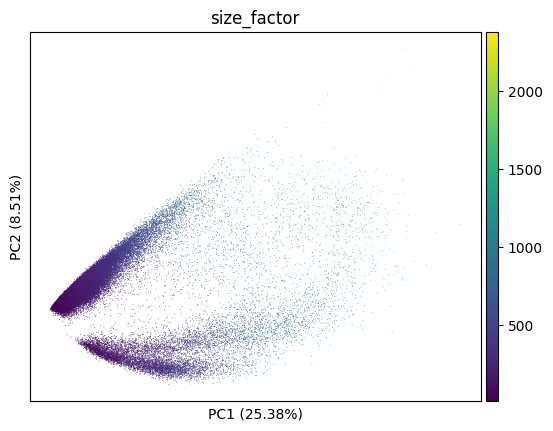

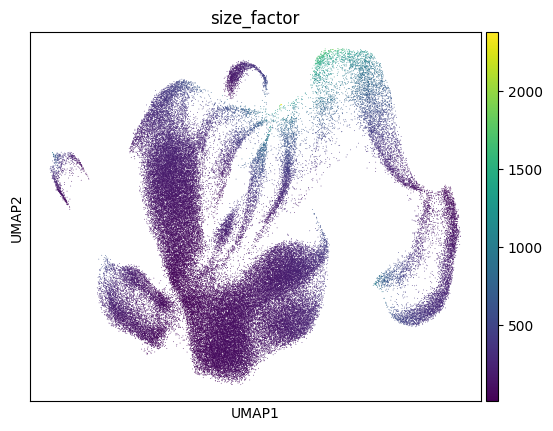

In [70]:
sc.pl.pca(adata_generated, color="size_factor", annotate_var_explained=True)
sc.pl.umap(adata_generated, color="size_factor")

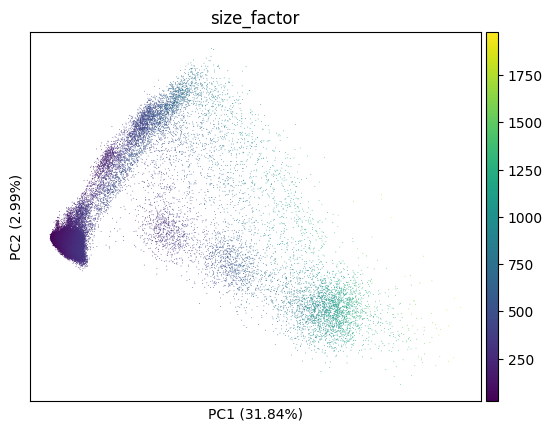

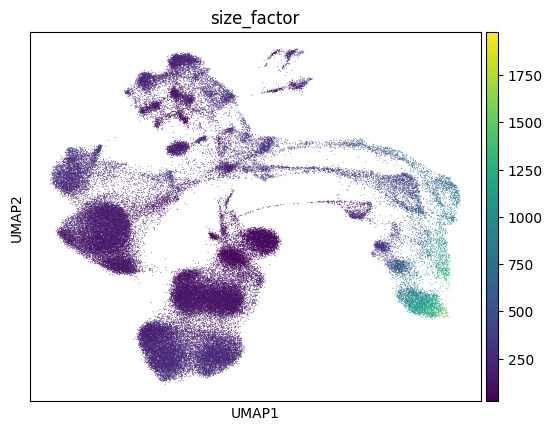

In [71]:
sc.pl.pca(adata_original, color="size_factor",  annotate_var_explained=True)
sc.pl.umap(adata_original, color="size_factor")

Merge and plot the generated and real data

In [72]:
dataset_type = ["Real" for _ in range(X.shape[0])] + ["Generated" for _ in range(X_generated_list.shape[0])]
dataset_type = pd.DataFrame(dataset_type)
dataset_type.columns = ["dataset_type"]
dataset_type["classes"] = list(adata_original.obs.cell_type)+list(classes_str)

In [73]:
# # If applicable 
# cell_type = list(adata_original.obs.clusters) + [condition_name for _ in range(X_generated.shape[0])]
# dataset_type["cell_type"] = cell_type

In [74]:
adata_merged = sc.AnnData(X=torch.cat([X, X_generated_list], dim=0).numpy(), 
                             obs=dataset_type)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [75]:
adata_merged

AnnData object with n_obs × n_vars = 180261 × 2002
    obs: 'dataset_type', 'classes'

In [76]:
sc.pp.log1p(adata_merged) 
sc.tl.pca(adata_merged)
sc.pp.neighbors(adata_merged)
sc.tl.umap(adata_merged)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


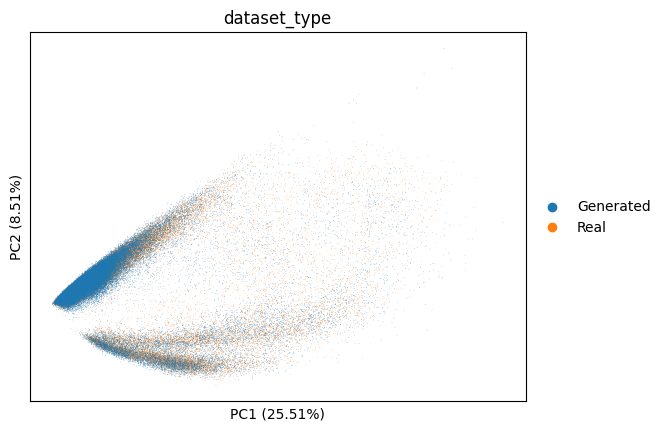

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoi

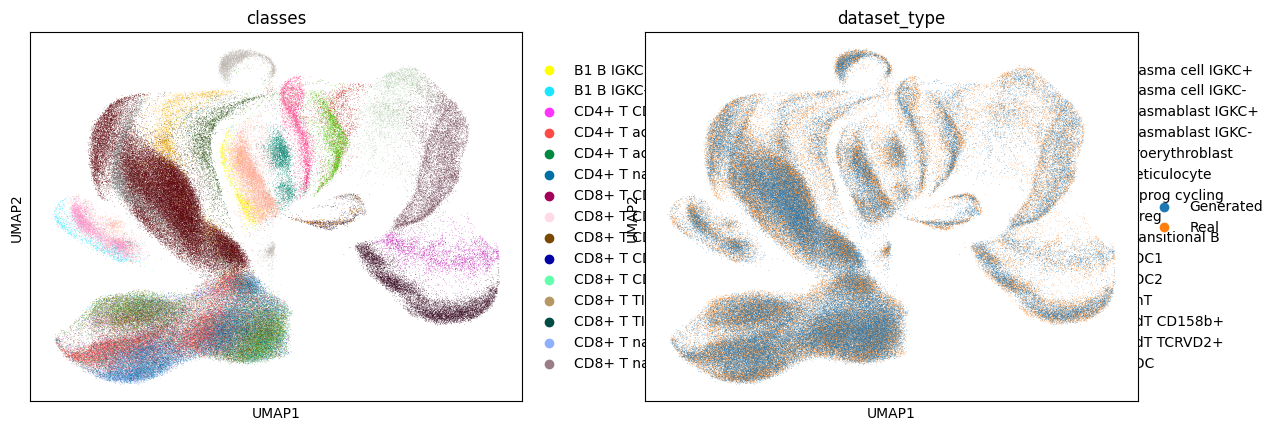

In [77]:
sc.pl.pca(adata_merged, color="dataset_type",  annotate_var_explained=True)
sc.pl.umap(adata_merged, color=["classes","dataset_type"])

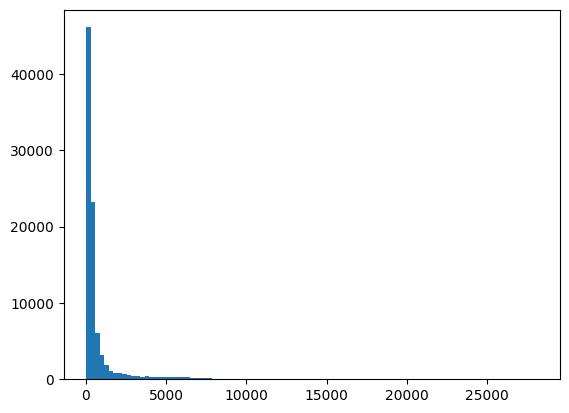

In [78]:
plt.hist(X.sum(1), 100)
plt.show()

In [79]:
(X_generated==0).sum(1).float().mean()

tensor(1785.6097)

In [80]:
(X==0).sum(1).float().mean()

tensor(1786.3540)

In [81]:
X.mean(1).mean()

tensor(0.3721)

In [82]:
X_generated.mean(1).mean()

tensor(0.3875)